# Convolutional Neural Networks
Convolutional Neural Networks are a class of networks, that are typically employed in the field of neural image processing.
Since fully connected layers for a large image would be prohibitively expensive, convolutions are used to vastly reduce the amount of parameters needed to process an image.

Instead of connecting every output to every input with individual weights, we reduce the number of parameters by sharing the weights and applying the same ones to different parts of the input image. This reduces the number of weights to be learned in a single layer and the number of layers by taking into account the nature of the input data (2D pixel map).

We use the Sequential model with Dense layers from before and add $\texttt{Conv2D}$, $\texttt{MaxPooling2D}$, $\texttt{Dropout}$ and $\texttt{Flatten}$ layers.


As an example task we classify the images in the MNIST dataset, a set of images of handwritten digits, with respect to which digit an image supposedly shows.

In [18]:
import h5py
import numpy as np
import scipy.signal as scis
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.utils import to_categorical

In [19]:
def load_data(path='mnist.h5'):
    with h5py.File(path, 'r') as handle:
        return np.array(handle['data']), np.array(handle['labels'])
    
data, labels = load_data()

A single convolution is a filter like in traditional image processing, except its individual weights are learned.
The same filter is applied to small sub-images at a time to produce a new image, that contains e.g. just the horizontal edges of the original image.

Any activation function that is aplicable for a dense layer works for a convolutional one. In hidden layers something like \emph{recitified linear unit} ('relu') is often useful:
$$ f(x) = max(x, 0)$$

Look at the following example filters and try to understand what they do:

In [20]:
gauss_filter = scis.convolve2d(data[0], np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]), mode='same')

laplacian_filter = scis.convolve2d(data[0], np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
]), mode='same')

high_pass_filter = scis.convolve2d(data[0], np.array([
    [-1, -1, -1],
    [-1,  9, -1],
    [-1, -1, -1]
]), mode='same')

sharpen = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5, -0.5],
    [-0.5,  8.5, -0.5],
    [-0.5, -0.5, -0.5]
]), mode='same')

sobel_x = scis.convolve2d(data[0], np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
]), mode='same')

sobel_y = scis.convolve2d(data[0], np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1,]
]), mode='same')

sobel = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

emboss_filter = scis.convolve2d(data[0], np.array([
    [-1, -1,  0],
    [-1,  0,  1],
    [ 0,  1,  1,]
]), mode='same')

In [21]:
gauss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [1,  4,  7,  2,  1],
    [4, 16, 26, 16,  4],
    [7, 26, 41, 26,  7],
    [4, 16, 26, 16,  4],
    [1,  4,  7,  4,  1],
]), mode='same')

laplacian_filter_5x5 = scis.convolve2d(data[0], np.array([
    [0, 0,   1, 0, 0],
    [0, 1,   2, 1, 0],
    [1, 2, -16, 2, 1],
    [0, 1,   2, 1, 0],
    [0, 0,   1, 0, 0]
]), mode='same')

high_pass_filter_5x5 = scis.convolve2d(data[0], np.array([
    [ 0, -1, -1, -1,  0],
    [-1,  2, -4,  2, -1],
    [-1, -4, 13, -4, -1],
    [-1,  2, -4,  2, -1],
    [ 0, -1, -1, -1,  0]
]), mode='same')

sharpen_5x5 = scis.convolve2d(data[0], np.array([
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  24.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
    [-0.5, -0.5,  -0.5, -0.5, -0.5],
]), mode='same')

sobel_x_5x5 = scis.convolve2d(data[0], np.array([
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2],
    [4, 2, 0, -2, -4],
    [2, 1, 0, -1, -2],
    [2, 1, 0, -1, -2]
]), mode='same')

sobel_y_5x5 = scis.convolve2d(data[0], np.array([
    [ 1,  1,  4,  1,  1],
    [ 1,  1,  2,  1,  1],
    [ 0,  0,  0,  0,  0],
    [-1, -1, -2, -1, -1],
    [-1, -1, -4, -1, -1],
]), mode='same')

sobel_5x5 = np.sqrt(sobel_x_5x5 ** 2 + sobel_y_5x5 ** 2)

emboss_filter_5x5 = scis.convolve2d(data[0], np.array([
    [-1, -1, -1, -1, 0],
    [-1, -1, -1,  0, 1],
    [-1, -1,  0,  1, 1],
    [-1,  0,  1,  1, 1],
    [ 0,  1,  1,  1, 1],
]), mode='same')

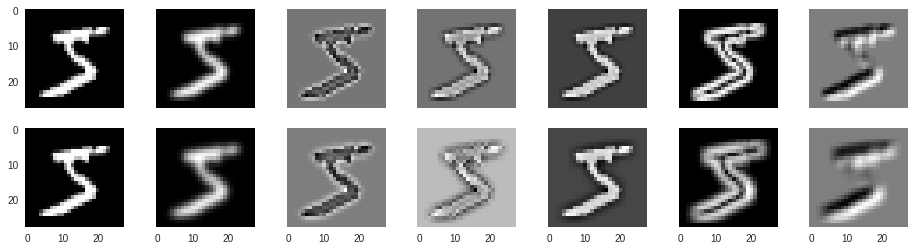

In [22]:
def show_examples(data):
    height = data.shape[0]
    width = data.shape[1]
    figure, axes = plt.subplots(height, width, figsize=(16, 4), sharex=True, sharey=True)
    
    for h in range(height):
        for w in range(width):
            axis = axes[h][w]
            axis.grid(False)
            axis.imshow(data[h, w, :, :], cmap='gist_gray')
    plt.show()

    
filtered_images = np.array([
    [data[0], gauss_filter,     laplacian_filter,     high_pass_filter,     sharpen,     sobel,     emboss_filter],
    [data[0], gauss_filter_5x5, laplacian_filter_5x5, high_pass_filter_5x5, sharpen_5x5, sobel_5x5, emboss_filter_5x5]
])
show_examples(filtered_images)

## Digit Recognition
To extract useful features from the image, several convolutional layers with a number of filters each, are applied directly to the image.
A convolutional layers produces another image as output, where the number of filters in the layers corresponds to the number of "color" channels in the output.
Convolutions by themselves can be used to slightly reduce the size of the image, or they can be padded (padding='same').
Another way is to use pooling layers (e.g. $\texttt{MaxPooling2D(size, strides)}$) to deliberately combine several outputs of a previous layer to a single input for the next one.

For classification tasks on images, like digit recognition, a final dense layer is still needed to do the actual classification.

Build an image classification model, that takes the correct input shape from the data and passes it through some convolutional, pooling and finally a dense layer and outputs the probability of the image belonging to each class.

Where and why would you need a $\texttt{Flatten}$ layer?

Train and test the model.

In [23]:
def preprocess_data(data, labels):
    return np.expand_dims(data, axis=3), to_categorical(labels)

preprocessed_data, preprocessed_labels = preprocess_data(data, labels)

In [27]:
def build_model(data, classes):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same', input_shape=data.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(preprocessed_data, classes=preprocessed_labels.shape[1])

In [28]:
class TrainingHistory(Callback):
    def on_train_begin(self, logs):
        self.loss = []
        self.acc = []
        self.validation_loss = []
        self.validation_acc = []
        
    def on_batch_end(self, _, logs):
        if 'loss' in logs:
            self.loss.append(logs['loss'])
        if 'acc' in logs:
            self.acc.append(logs['acc'])
            
    def on_epoch_end(self, _, logs):
        if 'val_loss' in logs:
            self.validation_loss.append(logs['val_loss'])
        if 'val_acc' in logs:
            self.validation_acc.append(logs['val_acc'])

In [29]:
def train_model(model, data, labels, epochs=25, batch_size=64, train_fraction=0.8):
    history = TrainingHistory()
    model.fit(
        data, 
        labels, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=1.0 - train_fraction, 
        shuffle=True,
        callbacks=[history]
    )
    return history
    
history = train_model(model, preprocessed_data, preprocessed_labels)

Train on 56000 samples, validate on 14000 samples
Epoch 1/30
56000/56000 [==============================] - 139s 2ms/step - loss: 0.6056 - acc: 0.8268 - val_loss: 0.1991 - val_acc: 0.9422
Epoch 2/30
56000/56000 [==============================] - 142s 3ms/step - loss: 0.2139 - acc: 0.9354 - val_loss: 0.1296 - val_acc: 0.9617
Epoch 3/30
56000/56000 [==============================] - 142s 3ms/step - loss: 0.1570 - acc: 0.9525 - val_loss: 0.1040 - val_acc: 0.9682
Epoch 4/30
56000/56000 [==============================] - 145s 3ms/step - loss: 0.1254 - acc: 0.9616 - val_loss: 0.0857 - val_acc: 0.9749
Epoch 5/30
56000/56000 [==============================] - 144s 3ms/step - loss: 0.1076 - acc: 0.9671 - val_loss: 0.0771 - val_acc: 0.9756
Epoch 6/30
56000/56000 [==============================] - 152s 3ms/step - loss: 0.0922 - acc: 0.9721 - val_loss: 0.0682 - val_acc: 0.9801
Epoch 7/30
56000/56000 [==============================] - 145s 3ms/step - loss: 0.0817 - acc: 0.9751 - val_loss: 0.0616 - 

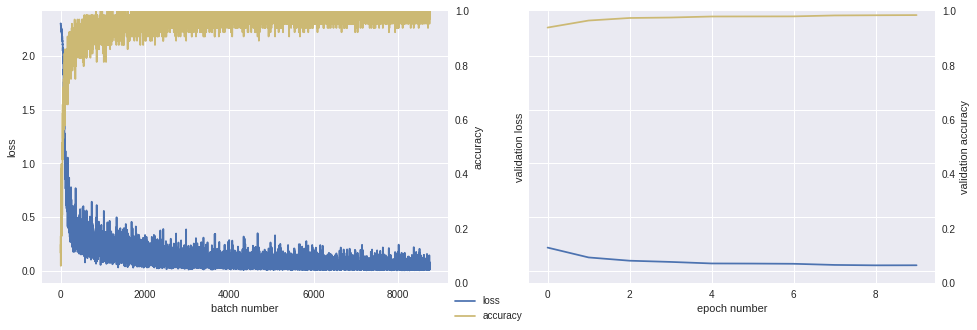

In [16]:
def plot_history(history):
    figure, (batch_axis, epoch_axis) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    # plot the training loss and accuracy
    batch_axis.set_xlabel('batch number')
    training_batches = np.arange(len(history.loss))
    
    batch_axis.plot(training_batches, history.loss, color='C0', label='loss')
    batch_axis.set_ylabel('loss')
    
    batch_acc_axis = batch_axis.twinx()
    batch_acc_axis.grid(False)
    batch_acc_axis.set_ylabel('accuracy')
    batch_acc_axis.set_ylim(bottom=0.0)
    batch_acc_axis.plot(training_batches, history.acc, color='C4', label='accuracy')
    
    # plot the training loss and accuracy
    epoch_axis.set_xlabel('epoch number')
    validation_epochs = np.arange(len(history.validation_loss))
    
    epoch_axis.plot(validation_epochs, history.validation_loss, color='C0')
    epoch_axis.set_ylabel('validation loss')
    
    epoch_acc_axis = epoch_axis.twinx()
    epoch_acc_axis.grid(False)
    epoch_acc_axis.set_ylabel('validation accuracy')
    epoch_acc_axis.set_ylim(bottom=0.0)
    epoch_acc_axis.plot(validation_epochs, history.validation_acc, color='C4')
    
    # display a legend
    figure.legend(loc=8)
    plt.show()

plot_history(history)

Next: add $\texttt{Dropout}$ layers and observe their effect on the history.
\emph{Dropout} is a technique to reduce overfitting to the training data by randomly selecting neurons and setting their activation to $0$.
The $\texttt{Dropout}$ layer in Keras just passes through its input, except in randomly selected positions, where it passes through $0$.

## Your convolutions
Look at the effect of your filters on the input. Compare to the example filters.

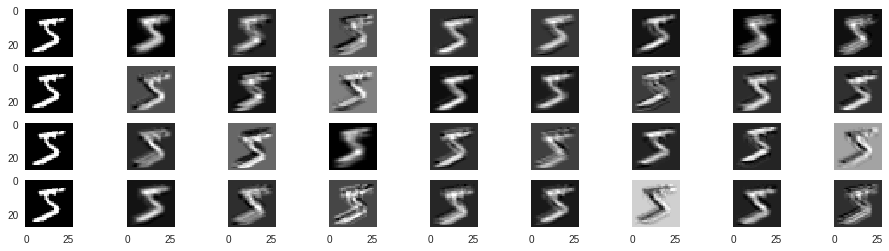

In [13]:
def apply_network_convolutions(image, weights):
    height, width = image.shape
    kernels_y, kernels_x = weights.shape[:2]
    
    output = np.zeros((kernels_y, kernels_x + 1, height, width), dtype=image.dtype)
    for y in range(kernels_y):
        for x in range(kernels_x + 1):
            if x == 0:
                output[y, x, :, :] = image
            else:
                output[y, x, :, :] = scis.convolve2d(image, weights[y, x - 1, :, :], mode='same')
    return output

weights = np.moveaxis(model.get_weights()[0], 0, -1).reshape(4, 8, 5, 5)
model_convolutions = apply_network_convolutions(data[0], weights)
show_examples(model_convolutions)

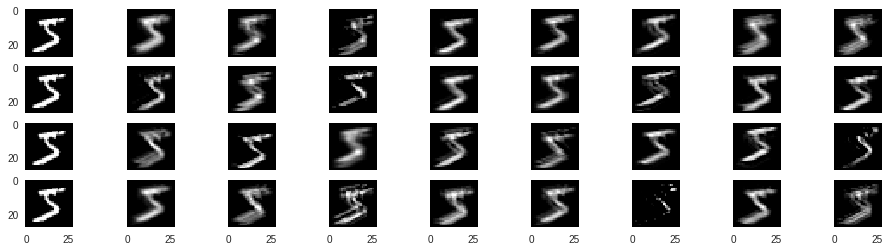

In [14]:
activated = model_convolutions.copy()
activated[activated < 0] = 0
show_examples(activated)

# Bonus:
Add an [inception layer](https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf) to your CNN and investigate its effect.
Simplified, an inception layer are multiple convolutional layers with different filter size in parallel. For more information, follow the link.